In [1]:
import sklearn.preprocessing
import sklearn.ensemble
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/Boss 直聘数据集-筛选后.csv', index_col=0)
df

,城市平均收入,月薪,学历限制,职业
0,34191,3.0,不限,服务类
3,26798,5.5,本科,服务类
7,62361,8.5,不限,服务类
13,57543,7.5,不限,服务类
15,64183,6.5,本科,服务类
...,...,...,...,...
264,62361,4.0,不限,教育类
265,48107,5.0,不限,教育类
266,39506,5.0,专科,教育类
267,26839,9.0,本科,教育类


In [3]:
education_encoder = sklearn.preprocessing.OneHotEncoder().fit(np.array(df['学历限制']).reshape(-1, 1))
work_encoder = sklearn.preprocessing.LabelEncoder().fit(df['职业'])

In [4]:
def process_education(education_array):
    return education_encoder.transform(np.array(education_array).reshape(-1, 1)).toarray()

def process_education_once(education):
    return education_encoder.transform(np.array([education]).reshape(-1, 1)).toarray()[0]

process_education_once('本科')

array([0., 0., 1.])

In [5]:
def pre_process(city_income, salary, education):
    return np.concatenate((np.array(city_income).reshape(-1,1),
                           np.array(salary).reshape(-1,1),
                           process_education(education)), axis=1)

pre_process(df['城市平均收入'],df['月薪'],df['学历限制'])

array([[3.4191e+04, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       [2.6798e+04, 5.5000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
       [6.2361e+04, 8.5000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       ...,
       [3.9506e+04, 5.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       [2.6839e+04, 9.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
       [3.5376e+04, 6.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]])

In [6]:
def pre_process_once(city_income, salary, education):
    return [city_income, salary] + process_education_once(education).tolist()

pre_process_once(40000, 5, '本科')

[40000, 5, 0.0, 0.0, 1.0]

In [7]:
def process_work(work_array):
    return work_encoder.transform(work_array)

process_work(df['职业'])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
class Model:
    def __init__(self):
        self.data = pre_process(df['城市平均收入'],df['月薪'],df['学历限制'])
        self.target = process_work(df['职业'])
        self.train_x, self.test_x, self.train_y, self.test_y = sklearn.model_selection.train_test_split(self.data, self.target)
        self.classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=236,
                                                                  max_depth=24,
                                                                  min_samples_leaf=8)

    def fit(self):
        self.classifier.fit(self.train_x, self.train_y)

    def predict(self, city_income, salary, education):
        return self.classifier.predict([pre_process_once(city_income, salary, education)])

In [15]:
model = Model()
model.classifier.fit(model.train_x, model.train_y)

RandomForestClassifier(max_depth=24, min_samples_leaf=8, n_estimators=236)

In [16]:
model.classifier.score(model.train_x, model.train_y)

0.6851851851851852

In [17]:
model.classifier.score(model.test_x, model.test_y)

0.6909090909090909

In [15]:
np.bincount(model.classifier.predict(model.train_x))

array([52, 96, 14], dtype=int64)

In [37]:
array = sklearn.decomposition.PCA(n_components=2).fit_transform(model.test_x)
matrix = np.mat(array)
label = model.classifier.predict(model.test_x)

In [59]:
dict = {}
for each in label:
    dict[each] = []
dict

{2: [], 0: [], 1: []}

In [63]:
for index, each in enumerate(label):
    dict[each].append((np.array(matrix[:,0]).flatten()[index],
                       np.array(matrix[:,1]).flatten()[index]))

In [71]:
np.bincount(model.classifier.predict(model.test_x))

array([20, 29,  6], dtype=int64)

In [64]:
dict[0]

[(-9455.290622268334, 2.5282486370204986),
 (-5687.291603620586, -3.605100903513873),
 (-7757.291489692136, -2.7565922726168535),
 (-5687.290507550805, 2.8934302700426153),
 (-4720.290858637866, 0.7310237122118826),
 (-15317.291128592406, 0.016295544561064232),
 (-14023.290641227244, 2.797687009637394),
 (12053.708277460697, -5.793154202391145),
 (16680.714568467163, 31.11906466008781),
 (-5179.291610888517, -3.690656353617075),
 (-4720.290521385627, 2.7305717656138784),
 (-6671.288469959322, 15.056440170969461),
 (14166.708112329214, -6.948836939633971),
 (1270.7083052629562, -4.726952402608138),
 (-9831.29078551504, 1.5917991166951013),
 (-9455.289694824673, 8.027005783875989),
 (-9455.290790894453, 1.5284746103195015),
 (21498.708007430647, -8.183664813958165),
 (21498.71239170977, 17.810459880267782),
 (-9455.290875207513, 1.0285875969690024)]

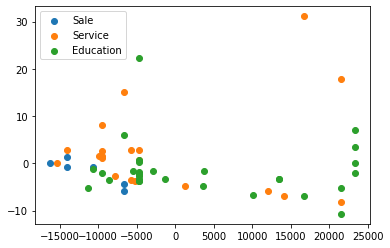

In [69]:
import matplotlib.pyplot as plt

label_list = ['Service','Education','Sale']
for each in dict:
    x_list = np.array(np.mat(dict[each])[:,0]).flatten()
    y_list = np.array(np.mat(dict[each])[:,1]).flatten()
    plt.scatter(x_list,y_list,label=label_list[each])
plt.legend()
plt.savefig('测试集结果分布.png')
